In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from ipywidgets import Label, Box
from IPython.display import display

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Define dataset placeholders
batch_size = tf.placeholder(tf.int64)
x_ph = tf.placeholder(tf.float32, [None, None, None], name="x")
y_ph = tf.placeholder(tf.int64, [None], name="y")
is_training_ph = tf.placeholder(tf.bool, name="is_training")

# Create dataset and iterator
dataset = tf.data.Dataset.from_tensor_slices((x_ph, y_ph)).batch(batch_size).repeat()
itr = dataset.make_initializable_iterator()

In [3]:
x, y = itr.get_next()
x = tf.expand_dims(x, 3)
#y = tf.one_hot(y, 10)

conv_1 = tf.layers.conv2d(x, 4, 3, padding="same", activation=tf.nn.relu)
pool_1 = tf.layers.max_pooling2d(conv_1, 2, 2, padding="same")

conv_2 = tf.layers.conv2d(pool_1, 8, 3, padding="same", activation=tf.nn.relu)
pool_2 = tf.layers.max_pooling2d(conv_2, 2, 2, padding="same")

conv_3 = tf.layers.conv2d(pool_2, 16, 7, padding="valid", activation=tf.nn.relu)

conv_4 = tf.layers.conv2d(conv_3, 10, 1, padding="same", activation=tf.nn.relu)

conv_4_shape = tf.shape(conv_4)

logits = tf.reduce_mean(conv_4, axis=[1, 2])

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))

train_op = tf.train.AdamOptimizer(0.001).minimize(loss)

# evaluate the accuracy of the model
correct_prediction = tf.equal(tf.argmax(logits, 1), y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [4]:
statusLabel = Label("")
display(Box([statusLabel]))

BATCH_SIZE = 200
EPOCHS = 10

MODEL_NAME = "conv4_run2"

#shutil.rmtree(os.path.join("logs", MODEL_NAME))

# Load MNIST data
train_data, test_data = tf.keras.datasets.mnist.load_data()
train_data = (train_data[0].astype(dtype=np.float32) / 255.0, train_data[1])
test_data = (test_data[0].astype(dtype=np.float32) / 255.0, test_data[1])

total_loss_ph = tf.placeholder(tf.float32)
accuracy_ph   = tf.placeholder(tf.float32)
tf.summary.scalar("loss", total_loss_ph)
tf.summary.scalar("accuracy", accuracy_ph)
merged = tf.summary.merge_all()
    
sess = tf.Session()

# Create file writers
train_summary = tf.summary.FileWriter(os.path.join("logs", MODEL_NAME, "train"), sess.graph, flush_secs=10)
val_summary   = tf.summary.FileWriter(os.path.join("logs", MODEL_NAME, "val"),   sess.graph, flush_secs=10)

# Initialize models vars
sess.run(tf.global_variables_initializer())

# Train loop
for epoch in range(EPOCHS):
    statusLabel.value = "Epoch {}/{}: Training...".format(epoch+1, EPOCHS)

    # Feed train data
    sess.run(itr.initializer, feed_dict={ x_ph: train_data[0], y_ph: train_data[1], batch_size: BATCH_SIZE })

    total_loss = 0.0
    total_accuracy = 0.0
    n_batches = len(train_data[0]) // BATCH_SIZE
    for _ in range(n_batches):
        _, loss_value, acc_value = sess.run([train_op, loss, accuracy], feed_dict={ is_training_ph: True })
        total_loss += loss_value
        total_accuracy += acc_value
    summary = sess.run(merged, feed_dict={total_loss_ph: total_loss, accuracy_ph: total_accuracy / n_batches})
    train_summary.add_summary(summary, epoch)

    statusLabel.value = "Epoch {}/{}: Evaluating...".format(epoch+1, EPOCHS)

    # Feed eval data
    sess.run(itr.initializer, feed_dict={ x_ph: test_data[0], y_ph: test_data[1], batch_size: BATCH_SIZE })

    total_loss = 0.0
    total_accuracy = 0.0
    n_batches = len(test_data[0]) // BATCH_SIZE
    for _ in range(n_batches):
        loss_value, acc_value = sess.run([loss, accuracy], feed_dict={ is_training_ph: True })
        total_loss += loss_value
        total_accuracy += acc_value
    summary = sess.run(merged, feed_dict={total_loss_ph: total_loss, accuracy_ph: total_accuracy / n_batches})
    val_summary.add_summary(summary, epoch)

train_summary.close()
val_summary.close()        

Label: 7
Predicted: 7


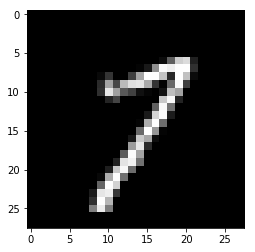

In [18]:
index = np.random.randint(0, len(test_data[0]))
x_test = test_data[0][index]
y_test = test_data[1][index]

plt.imshow(x_test, cmap="gray")

batch_xs = np.expand_dims(x_test, 0)
batch_ys = np.expand_dims(y_test, 0)
print("Label:", batch_ys[0])

sess.run(itr.initializer, feed_dict={ x_ph: batch_xs, y_ph: batch_ys, batch_size: 1 })
prob = sess.run(logits, feed_dict={ is_training_ph: False })
print("Predicted:", np.argmax(prob, axis=1)[0])

In [6]:
import math
def getActivations(layer):
    sess.run(itr.initializer, feed_dict={ x_ph: batch_xs, y_ph: batch_ys, batch_size: 1 })
    units = sess.run(layer, feed_dict={ is_training_ph: False })
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

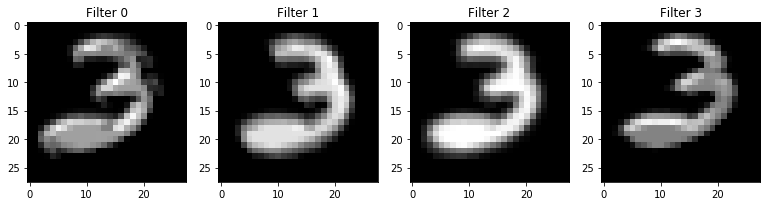

In [7]:
getActivations(conv_1)

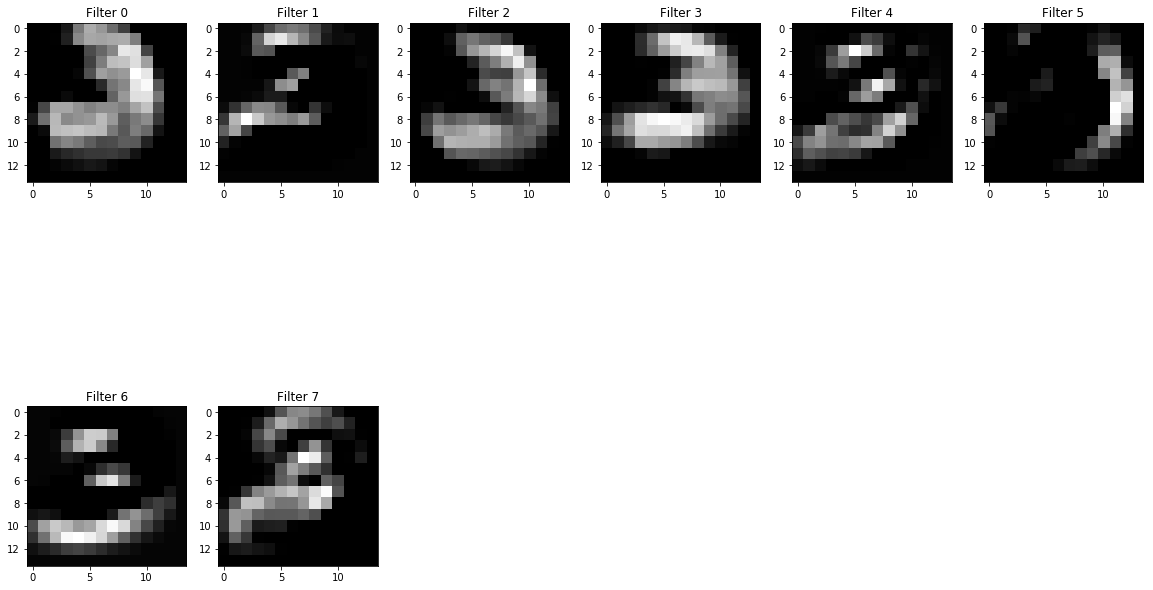

In [8]:
getActivations(conv_2)

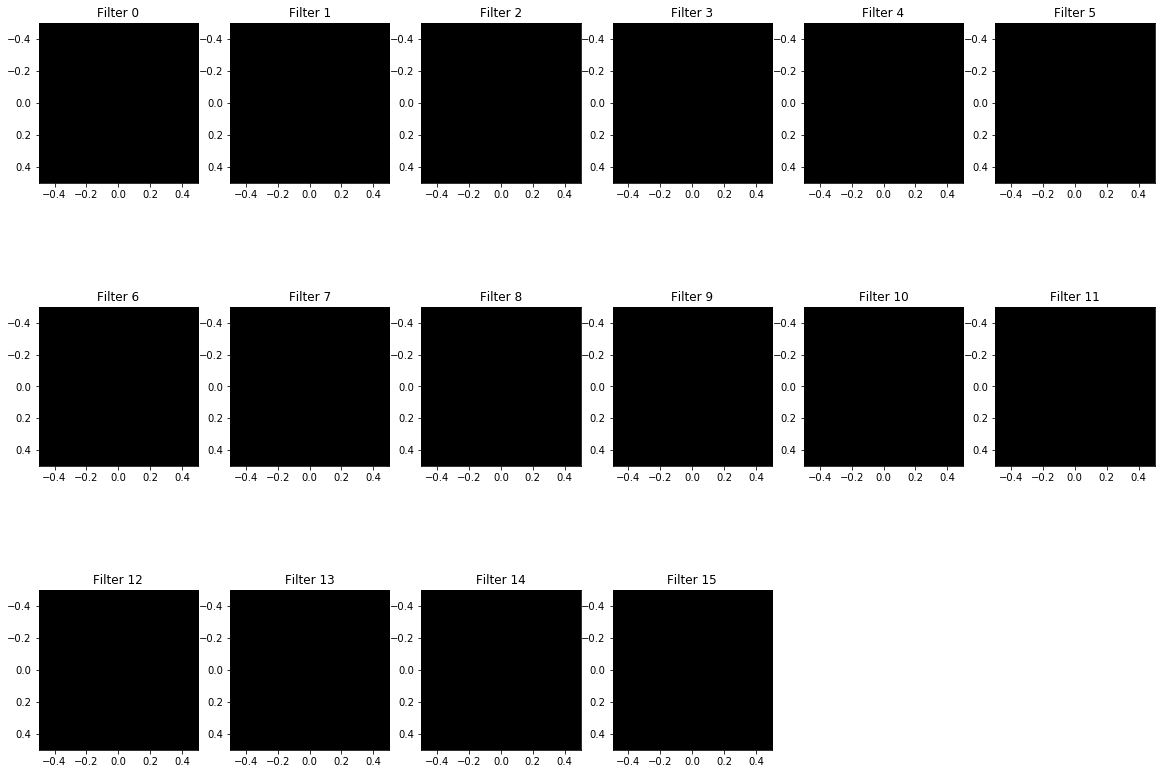

In [9]:
getActivations(conv_3)

In [10]:
print(prob)

[[15.633988    2.212878   21.979961   26.256699    0.         10.248389
   0.09036443 11.84777    12.655936   11.402651  ]]


Label: 4
Predicted: 5


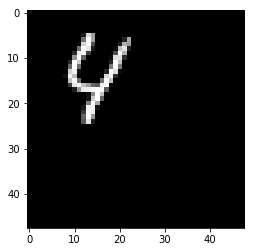

In [74]:
import skimage.transform

index = np.random.randint(0, len(test_data[0]))
x_test_o = test_data[0][index]
y_test = test_data[1][index]

x_test = np.zeros((48, 48))

x_test[:28, :28] = x_test_o#skimage.transform.resize(x_test_o, (48, 48))

plt.imshow(x_test, cmap="gray")

batch_xs = np.expand_dims(x_test, 0)
batch_ys = np.expand_dims(y_test, 0)
print("Label:", batch_ys[0])

sess.run(itr.initializer, feed_dict={ x_ph: batch_xs, y_ph: batch_ys, batch_size: 1 })
prob, sh = sess.run([logits, conv_4_shape], feed_dict={ is_training_ph: False })
print("Predicted:", np.argmax(prob, axis=1)[0])